In [ ]:
# Mount "My Drive" into /content/drive
from google.colab import drive

google_drive_dir = "Final_project"  # @param
#bml-notebooks/
drive.mount('/content/drive')

mount_point = "/content/drive/My Drive/{}".format(google_drive_dir)

# Change the root directory to your mount_point
% cd '$mount_point'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Final_project


# <span style="color: royalblue;">Load Data</span>
Load the image data with labels.

In [ ]:
import numpy as np
from src.loadData import loadFer2013
from keras.utils import to_categorical


In [ ]:
X_train,X_val,X_test,y_train,y_val,y_test = loadFer2013('fer2013/icml_face_data.csv')

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

/content/drive/My Drive/Final_project/src/loadData.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['emotion'][data['emotion']>1]-=1


In [ ]:
y_train_onehot.shape, y_val_onehot.shape, y_test_onehot.shape

((28709, 6), (3589, 6), (3589, 6))

In [ ]:
X_train.shape, y_train.shape

((28709, 48, 48), (28709,))

In [ ]:
emotions = {0: 'Angry', 1:'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise', 5: 'Neutral'}

In [ ]:
class_names = list(emotions.values())
class_names

['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [ ]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index())
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

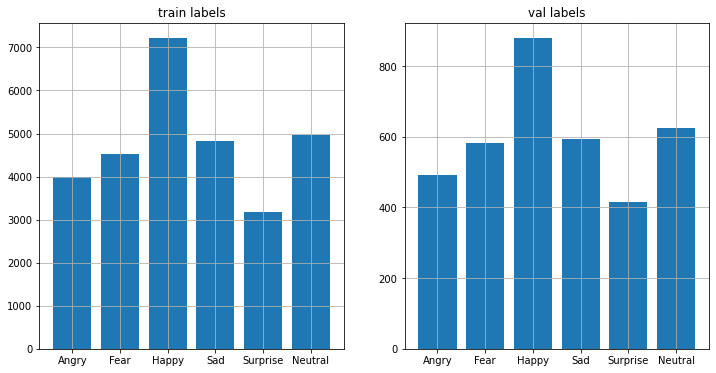

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plot_compare_distributions(y_train_onehot, y_val_onehot, title1='train labels', title2='val labels')

#Preprocessing

In [ ]:
def preprocessX(X):
    X = np.expand_dims(X,axis=-1)
    return X/255

X_processed_train = preprocessX(X_train)
X_processed_val = preprocessX(X_val)
X_processed_test = preprocessX(X_test)
X_processed_train.shape,X_processed_val.shape,X_processed_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1), (3589, 48, 48, 1))

# Extract features

In [ ]:
from keras import models, Model, utils
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [ ]:
lr=1e-3
epochs=20
batch_size = 64
decay = lr/epochs
adam = Adam(lr=lr)


In [ ]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [ ]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_filepath = 'keras_model/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

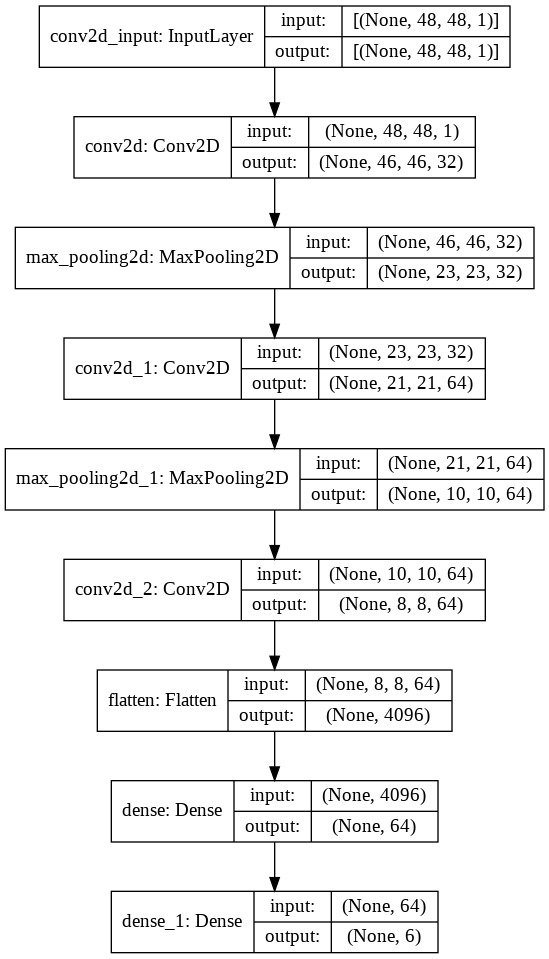

In [ ]:
utils.plot_model(model, to_file='archi.png', show_shapes=True)

In [ ]:
!pip install visualkeras

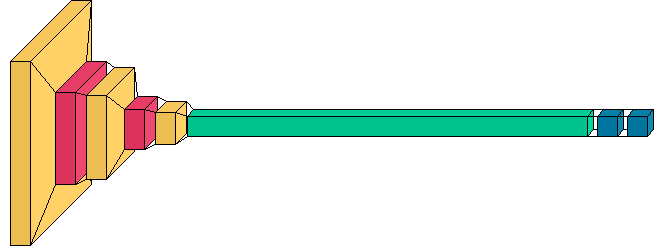

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
history = model.fit(X_processed_train,y_train_onehot,
                    validation_data=(X_processed_val, y_val_onehot),
                    epochs=epochs,
                    batch_size=64,
                    callbacks=[model_checkpoint_callback])

Epoch 1/20
449/449 [==============================] - 10s 7ms/step - loss: 1.6874 - accuracy: 0.2953 - val_loss: 1.4525 - val_accuracy: 0.4202
Epoch 2/20
449/449 [==============================] - 3s 6ms/step - loss: 1.4132 - accuracy: 0.4363 - val_loss: 1.3162 - val_accuracy: 0.4815
Epoch 3/20
449/449 [==============================] - 3s 6ms/step - loss: 1.2843 - accuracy: 0.4921 - val_loss: 1.2899 - val_accuracy: 0.4985
Epoch 4/20
449/449 [==============================] - 3s 6ms/step - loss: 1.2099 - accuracy: 0.5350 - val_loss: 1.2346 - val_accuracy: 0.5157
Epoch 5/20
449/449 [==============================] - 3s 6ms/step - loss: 1.1564 - accuracy: 0.5529 - val_loss: 1.2126 - val_accuracy: 0.5224
Epoch 6/20
449/449 [==============================] - 3s 6ms/step - loss: 1.1000 - accuracy: 0.5746 - val_loss: 1.1888 - val_accuracy: 0.5394
Epoch 7/20
449/449 [==============================] - 3s 6ms/step - loss: 1.0601 - accuracy: 0.5912 - val_loss: 1.1894 - val_accuracy: 0.5469
Epoch

In [ ]:
model.load_weights(checkpoint_filepath)
model.evaluate(X_processed_test,y_test_onehot)

113/113 [==============================] - 0s 3ms/step - loss: 1.2025 - accuracy: 0.5464


[1.202513337135315, 0.5463917255401611]

In [ ]:
model.predict(X_processed_test[:1]).shape

(1, 6)

In [ ]:
np.argmax(model.predict(X_processed_test[1:4]))

6

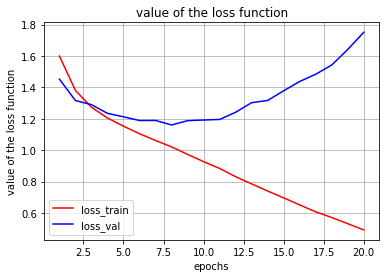

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'r', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

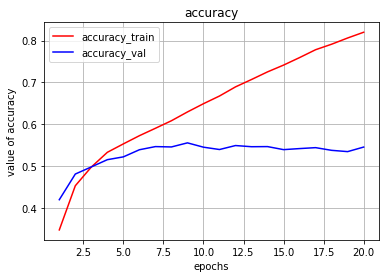

In [ ]:

acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'r', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Quantitative evaluation of the model quality on the test set
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Predicting people's names on the test set")
t0 = time.time()
y_pred = svm.predict(X_processed_test)
print("done in %0.3fs" % (time.time() - t0))

print(classification_report(y_test_onehot, y_pred, target_names=class_names))
# print(confusion_matrix(y_test, y_pred, labels=range(len(class_names))))

Predicting people's names on the test set


NameError: ignored